MOAI 2020 Body Morphometry AI Segmentation Online Challenge

Install Segmentation Model [link](https://segmentation-models.readthedocs.io/en/latest/api.html#linknet)

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

Set up Image Augmentation

In [4]:
import numpy as np
import matplotlib.pyplot as plt


from tensorflow.keras.preprocessing.image import ImageDataGenerator

MASK_COLORS = [
    "red", "green", "blue",
    "yellow", "magenta", "cyan"
]


# Runtime data augmentation
def get_augmented(
    X_train,
    Y_train,
    X_val=None,
    Y_val=None,
    batch_size=32,
    s=10,
    data_gen_args=dict(
        rotation_range=10.0,
        # width_shift_range=0.02,
        height_shift_range=0.02,
        shear_range=5,
        # zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode="constant",
    ),
):
    """[summary]
    
    Args:
        X_train (numpy.ndarray): [description]
        Y_train (numpy.ndarray): [description]
        X_val (numpy.ndarray, optional): [description]. Defaults to None.
        Y_val (numpy.ndarray, optional): [description]. Defaults to None.
        batch_size (int, optional): [description]. Defaults to 32.
        seed (int, optional): [description]. Defaults to 0.
        data_gen_args ([type], optional): [description]. Defaults to dict(rotation_range=10.0,# width_shift_range=0.02,height_shift_range=0.02,shear_range=5,# zoom_range=0.3,horizontal_flip=True,vertical_flip=False,fill_mode="constant",).
    
    Returns:
        [type]: [description]
    """

    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=s)
    Y_datagen.fit(Y_train, augment=True, seed=s)
    X_train_augmented = X_datagen.flow(
        X_train, batch_size=batch_size, shuffle=True, seed=s
    )
    Y_train_augmented = Y_datagen.flow(
        Y_train, batch_size=batch_size, shuffle=True, seed=s
    )

    train_generator = zip(X_train_augmented, Y_train_augmented)

    if not (X_val is None) and not (Y_val is None):
        # Validation data, no data augmentation, but we create a generator anyway
        X_datagen_val = ImageDataGenerator(**data_gen_args)
        Y_datagen_val = ImageDataGenerator(**data_gen_args)
        X_datagen_val.fit(X_val, augment=False, seed=s)
        Y_datagen_val.fit(Y_val, augment=False, seed=s)
        X_val_augmented = X_datagen_val.flow(
            X_val, batch_size=batch_size, shuffle=False, seed=s
        )
        Y_val_augmented = Y_datagen_val.flow(
            Y_val, batch_size=batch_size, shuffle=False, seed=s
        )

        # combine generators into one which yields image and masks
        val_generator = zip(X_val_augmented, Y_val_augmented)

        return train_generator, val_generator
    else:
        return train_generator


def plot_segm_history(history, metrics=["iou", "val_iou"], losses=["loss", "val_loss"]):
    """[summary]
    
    Args:
        history ([type]): [description]
        metrics (list, optional): [description]. Defaults to ["iou", "val_iou"].
        losses (list, optional): [description]. Defaults to ["loss", "val_loss"].
    """
    # summarize history for iou
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(history.history[metric], linewidth=3)
    plt.suptitle("metrics over epochs", fontsize=20)
    plt.ylabel("metric", fontsize=20)
    plt.xlabel("epoch", fontsize=20)
    # plt.yticks(np.arange(0.3, 1, step=0.02), fontsize=35)
    # plt.xticks(fontsize=35)
    plt.legend(metrics, loc="center right", fontsize=15)
    plt.show()
    # summarize history for loss
    plt.figure(figsize=(12, 6))
    for loss in losses:
        plt.plot(history.history[loss], linewidth=3)
    plt.suptitle("loss over epochs", fontsize=20)
    plt.ylabel("loss", fontsize=20)
    plt.xlabel("epoch", fontsize=20)
    # plt.yticks(np.arange(0, 0.2, step=0.005), fontsize=35)
    # plt.xticks(fontsize=35)
    plt.legend(losses, loc="center right", fontsize=15)
    plt.show()


def mask_to_red(mask):
    """
    Converts binary segmentation mask from white to red color.
    Also adds alpha channel to make black background transparent.
    
    Args:
        mask (numpy.ndarray): [description]
    
    Returns:
        numpy.ndarray: [description]
    """
    img_size = mask.shape[0]
    c1 = mask.reshape(img_size, img_size)
    c2 = np.zeros((img_size, img_size))
    c3 = np.zeros((img_size, img_size))
    c4 = mask.reshape(img_size, img_size)
    return np.stack((c1, c2, c3, c4), axis=-1)


def mask_to_rgba(mask, color="red"):
    """
    Converts binary segmentation mask from white to red color.
    Also adds alpha channel to make black background transparent.
    
    Args:
        mask (numpy.ndarray): [description]
        color (str, optional): Check `MASK_COLORS` for available colors. Defaults to "red".
    
    Returns:
        numpy.ndarray: [description]
    """    
    assert(color in MASK_COLORS)
    assert(mask.ndim==3 or mask.ndim==2)

    h = mask.shape[0]
    w = mask.shape[1]
    zeros = np.zeros((h, w))
    ones = mask.reshape(h, w)
    if color == "red":
        return np.stack((ones, zeros, zeros, ones), axis=-1)
    elif color == "green":
        return np.stack((zeros, ones, zeros, ones), axis=-1)
    elif color == "blue":
        return np.stack((zeros, zeros, ones, ones), axis=-1)
    elif color == "yellow":
        return np.stack((ones, ones, zeros, ones), axis=-1)
    elif color == "magenta":
        return np.stack((ones, zeros, ones, ones), axis=-1)
    elif color == "cyan":
        return np.stack((zeros, ones, ones, ones), axis=-1)


def plot_imgs(
        org_imgs,
        mask_imgs,
        pred_imgs=None,
        nm_img_to_plot=10,
        figsize=4,
        alpha=0.5,
        color="red"):
    """
    Image plotting for semantic segmentation data.
    Last column is always an overlay of ground truth or prediction
    depending on what was provided as arguments.
    Args:
        org_imgs (numpy.ndarray): Array of arrays representing a collection of original images.
        mask_imgs (numpy.ndarray): Array of arrays representing a collection of mask images (grayscale).
        pred_imgs (numpy.ndarray, optional): Array of arrays representing a collection of prediction masks images.. Defaults to None.
        nm_img_to_plot (int, optional): How many images to display. Takes first N images. Defaults to 10.
        figsize (int, optional): Matplotlib figsize. Defaults to 4.
        alpha (float, optional): Transparency for mask overlay on original image. Defaults to 0.5.
        color (str, optional): Color for mask overlay. Defaults to "red".
    """ # NOQA E501
    assert(color in MASK_COLORS)

    if nm_img_to_plot > org_imgs.shape[0]:
        nm_img_to_plot = org_imgs.shape[0]
    im_id = 0
    org_imgs_size = org_imgs.shape[1]

    org_imgs = reshape_arr(org_imgs)
    mask_imgs = reshape_arr(mask_imgs)
    if not (pred_imgs is None):
        cols = 4
        pred_imgs = reshape_arr(pred_imgs)
    else:
        cols = 3

    fig, axes = plt.subplots(
        nm_img_to_plot, cols, figsize=(cols * figsize, nm_img_to_plot * figsize), squeeze=False
    )
    axes[0, 0].set_title("original", fontsize=15)
    axes[0, 1].set_title("ground truth", fontsize=15)
    if not (pred_imgs is None):
        axes[0, 2].set_title("prediction", fontsize=15)
        axes[0, 3].set_title("overlay", fontsize=15)
    else:
        axes[0, 2].set_title("overlay", fontsize=15)
    for m in range(0, nm_img_to_plot):
        axes[m, 0].imshow(org_imgs[im_id], cmap=get_cmap(org_imgs))
        axes[m, 0].set_axis_off()
        axes[m, 1].imshow(mask_imgs[im_id], cmap=get_cmap(mask_imgs))
        axes[m, 1].set_axis_off()
        if not (pred_imgs is None):
            axes[m, 2].imshow(pred_imgs[im_id], cmap=get_cmap(pred_imgs))
            axes[m, 2].set_axis_off()
            axes[m, 3].imshow(org_imgs[im_id], cmap=get_cmap(org_imgs))
            axes[m, 3].imshow(
                mask_to_rgba(
                    zero_pad_mask(pred_imgs[im_id], desired_size=org_imgs_size),
                    color=color,
                ),
                cmap=get_cmap(pred_imgs),
                alpha=alpha,
            )
            axes[m, 3].set_axis_off()
        else:
            axes[m, 2].imshow(org_imgs[im_id], cmap=get_cmap(org_imgs))
            axes[m, 2].imshow(
                mask_to_rgba(
                    zero_pad_mask(mask_imgs[im_id], desired_size=org_imgs_size),
                    color=color,
                ),
                cmap=get_cmap(mask_imgs),
                alpha=alpha,
            )
            axes[m, 2].set_axis_off()
        im_id += 1

    plt.show()


def zero_pad_mask(mask, desired_size):
    """[summary]
    
    Args:
        mask (numpy.ndarray): [description]
        desired_size ([type]): [description]
    
    Returns:
        numpy.ndarray: [description]
    """
    pad = (desired_size - mask.shape[0]) // 2
    padded_mask = np.pad(mask, pad, mode="constant")
    return padded_mask


def reshape_arr(arr):
    """[summary]
    
    Args:
        arr (numpy.ndarray): [description]
    
    Returns:
        numpy.ndarray: [description]
    """
    if arr.ndim == 3:
        return arr
    elif arr.ndim == 4:
        if arr.shape[3] == 3:
            return arr
        elif arr.shape[3] == 1:
            return arr.reshape(arr.shape[0], arr.shape[1], arr.shape[2])


def get_cmap(arr):
    """[summary]
    
    Args:
        arr (numpy.ndarray): [description]
    
    Returns:
        string: [description]
    """
    if arr.ndim == 3:
        return "gray"
    elif arr.ndim == 4:
        if arr.shape[3] == 3:
            return "jet"
        elif arr.shape[3] == 1:
            return "gray"


def get_patches(img_arr, size=256, stride=256):
    """
    Takes single image or array of images and returns
    crops using sliding window method.
    If stride < size it will do overlapping.
    
    Args:
        img_arr (numpy.ndarray): [description]
        size (int, optional): [description]. Defaults to 256.
        stride (int, optional): [description]. Defaults to 256.
    
    Raises:
        ValueError: [description]
        ValueError: [description]
    
    Returns:
        numpy.ndarray: [description]
    """    
    # check size and stride
    if size % stride != 0:
        raise ValueError("size % stride must be equal 0")

    patches_list = []
    overlapping = 0
    if stride != size:
        overlapping = (size // stride) - 1

    if img_arr.ndim == 3:
        i_max = img_arr.shape[0] // stride - overlapping

        for i in range(i_max):
            for j in range(i_max):
                # print(i*stride, i*stride+size)
                # print(j*stride, j*stride+size)
                patches_list.append(
                    img_arr[
                        i * stride : i * stride + size,
                        j * stride : j * stride + size
                    ]
                )

    elif img_arr.ndim == 4:
        i_max = img_arr.shape[1] // stride - overlapping
        for im in img_arr:
            for i in range(i_max):
                for j in range(i_max):
                    # print(i*stride, i*stride+size)
                    # print(j*stride, j*stride+size)
                    patches_list.append(
                        im[
                            i * stride : i * stride + size,
                            j * stride : j * stride + size,
                        ]
                    )

    else:
        raise ValueError("img_arr.ndim must be equal 3 or 4")

    return np.stack(patches_list)


def plot_patches(img_arr, org_img_size, stride=None, size=None):
    """
    Plots all the patches for the first image in 'img_arr' trying to reconstruct the original image
    Args:
        img_arr (numpy.ndarray): [description]
        org_img_size (tuple): [description]
        stride ([type], optional): [description]. Defaults to None.
        size ([type], optional): [description]. Defaults to None.
    Raises:
        ValueError: [description]
    """

    # check parameters
    if type(org_img_size) is not tuple:
        raise ValueError("org_image_size must be a tuple")

    if img_arr.ndim == 3:
        img_arr = np.expand_dims(img_arr, axis=0)

    if size is None:
        size = img_arr.shape[1]

    if stride is None:
        stride = size

    i_max = (org_img_size[0] // stride) + 1 - (size // stride)
    j_max = (org_img_size[1] // stride) + 1 - (size // stride)

    fig, axes = plt.subplots(i_max, j_max, figsize=(i_max * 2, j_max * 2))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    jj = 0
    for i in range(i_max):
        for j in range(j_max):
            axes[i, j].imshow(img_arr[jj])
            axes[i, j].set_axis_off()
            jj += 1


def reconstruct_from_patches(img_arr, org_img_size, stride=None, size=None):
    """[summary]
    
    Args:
        img_arr (numpy.ndarray): [description]
        org_img_size (tuple): [description]
        stride ([type], optional): [description]. Defaults to None.
        size ([type], optional): [description]. Defaults to None.
    
    Raises:
        ValueError: [description]
    
    Returns:
        numpy.ndarray: [description]
    """
    # check parameters
    if type(org_img_size) is not tuple:
        raise ValueError("org_image_size must be a tuple")

    if img_arr.ndim == 3:
        img_arr = np.expand_dims(img_arr, axis=0)

    if size is None:
        size = img_arr.shape[1]

    if stride is None:
        stride = size

    nm_layers = img_arr.shape[3]

    i_max = (org_img_size[0] // stride) + 1 - (size // stride)
    j_max = (org_img_size[1] // stride) + 1 - (size // stride)

    total_nm_images = img_arr.shape[0] // (i_max ** 2)
    nm_images = img_arr.shape[0]

    averaging_value = size // stride
    images_list = []
    kk = 0
    for img_count in range(total_nm_images):
        img_bg = np.zeros(
            (org_img_size[0], org_img_size[1], nm_layers), dtype=img_arr[0].dtype
        )

        for i in range(i_max):
            for j in range(j_max):
                for layer in range(nm_layers):
                    img_bg[
                        i * stride : i * stride + size,
                        j * stride : j * stride + size,
                        layer,
                    ] = img_arr[kk, :, :, layer]

                kk += 1
        # TODO add averaging for masks - right now it's just overwritting

        #         for layer in range(nm_layers):
        #             # average some more because overlapping 4 patches
        #             img_bg[stride:i_max*stride, stride:i_max*stride, layer] //= averaging_value
        #             # corners:
        #             img_bg[0:stride, 0:stride, layer] *= averaging_value
        #             img_bg[i_max*stride:i_max*stride+stride, 0:stride, layer] *= averaging_value
        #             img_bg[i_max*stride:i_max*stride+stride, i_max*stride:i_max*stride+stride, layer] *= averaging_value
        #             img_bg[0:stride, i_max*stride:i_max*stride+stride, layer] *= averaging_value

        images_list.append(img_bg)

    return np.stack(images_list)

Lib to read dicom images

In [5]:
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import pydicom

def transform_to_hu(medical_image, image):
    hu_image = image * medical_image.RescaleSlope + medical_image.RescaleIntercept
    hu_image[hu_image < -1024] = -1024
    return hu_image

def window_image(image, window_center, window_width):
    window_image = image.copy()
    image_min = window_center - (window_width / 2)
    image_max = window_center + (window_width / 2)
    window_image[window_image < image_min] = image_min
    window_image[window_image > image_max] = image_max
    return window_image

def resize_normalize(image):
    image = np.array(image, dtype=np.float64)
    image -= np.min(image)
    image /= np.max(image)
    return image

def read_dicom(path, window_widht, window_level):
    image_medical = pydicom.dcmread(path)
    image_data = image_medical.pixel_array

    image_hu = transform_to_hu(image_medical, image_data)
    image_window = window_image(image_hu.copy(), window_level, window_widht)
    image_window_norm = resize_normalize(image_window)
#     image_window_norm = image_window

    image_window_norm = np.expand_dims(image_window_norm, axis=2)   # (512, 512, 1)
    image_ths = np.concatenate([image_window_norm, image_window_norm, image_window_norm], axis=2)   # (512, 512, 3)
    return image_ths

Show examples

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt', 'get_cmap']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


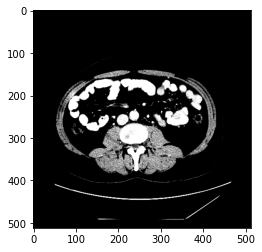

In [6]:
import matplotlib.pylab as plt

# specify your image path
image_path = "../input/body-morphometry-for-sarcopenia/train/DICOM/case072.dcm"
im = read_dicom(image_path, 100, 50)
%pylab inline
imgplot = plt.imshow(im)
plt.show()

(array([659886.,   6000.,   7488.,   8397.,  13440.,  18660.,  14700.,
          7857.,   5022.,  44982.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

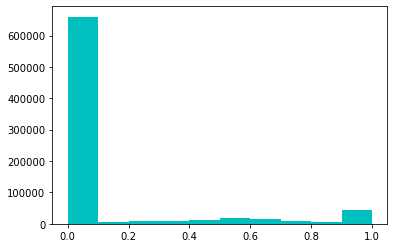

In [7]:
plt.hist(im.flatten(), color='c')

Read mask values

In [ ]:
np.unique(im)

Populating the interactive namespace from numpy and matplotlib


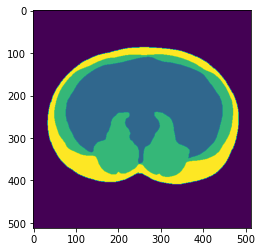

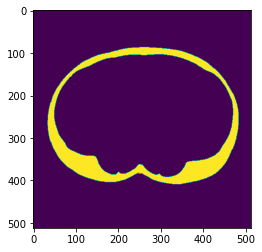

In [8]:
import cv2
import pydicom
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
im = mpimg.imread("../input/body-morphometry-for-sarcopenia/train/Label/case001.png")
im = np.around(im, 8)
mask_1 = im <= 0.00784314
mask_2 = im >= 0.01176471
mask_3 = np.logical_and(mask_1, mask_2)
mask_3
# im = np.expand_dims(im, axis=-1)
%pylab inline
imgplot = plt.imshow(im)
plt.show()
mask_3_int = mask_2.astype(float)
imgplot = plt.imshow(mask_3_int)
plt.show()

In [12]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3
TRAIN_PATH_IMAGE = '../input/body-morphometry-for-sarcopenia/train/DICOM/'
TRAIN_PATH_MASKS = '../input/body-morphometry-for-sarcopenia/train/Label/'
TEST_PATH = '../input/body-morphometry-for-sarcopenia/test/DICOM/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

In [13]:
# Get train and test IDs
train_ids = [f for f in sorted(os.listdir(TRAIN_PATH_IMAGE)) if os.path.isfile(os.path.join(TRAIN_PATH_IMAGE, f))]
test_ids = [f for f in sorted(os.listdir(TEST_PATH)) if os.path.isfile(os.path.join(TEST_PATH, f))]

In [16]:
def get_mask_innest(mask):
    mask_1 = mask < 0.00784314
    mask_2 = mask >= 0.00392157
    mask_3 = np.logical_and(mask_1, mask_2)
    mask_3_int = mask_3.astype(float)
    return mask_3_int

def get_mask_middle(mask):
    mask_1 = mask < 0.01176471
    mask_2 = mask >= 0.00784314
    mask_3 = np.logical_and(mask_1, mask_2)
    mask_3_int = mask_3.astype(float)
    return mask_3_int

def get_mask_outtest(mask):
    mask_1 = mask < 0.01176471
    mask_2 = mask >= 0.01176471
    mask_3 = np.logical_and(mask_1, mask_2)
    mask_3_int = mask_2.astype(float)
    return mask_3_int

Prepare DATA

In [17]:
# Get and resize train images and masks for region inside 
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    if id_ == 'case001.dcm':
        print(n)
    path = TRAIN_PATH_IMAGE + id_
    img = read_dicom(path, 100, 50)
    X_train[n] = img
    mask_path = TRAIN_PATH_MASKS + id_.replace('dcm', 'png')
    mask = mpimg.imread(mask_path)
    mask = np.around(mask, 8)

    m_in = get_mask_innest(mask)
    m_md = get_mask_middle(mask)
    m_ot = get_mask_outtest(mask)
    
    m_in = np.expand_dims(m_in, axis=-1)
    m_md = np.expand_dims(m_md, axis=-1)
    m_ot = np.expand_dims(m_ot, axis=-1)
    
    m_fn = np.concatenate([m_in, m_md, m_ot], axis=-1)
    
    Y_train[n] = m_fn

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = read_dicom(path, 100, 50)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


  5%|▌         | 5/100 [00:00<00:02, 41.45it/s]

0


100%|██████████| 100/100 [00:02<00:00, 38.06it/s]

Getting and resizing test images ... 



100%|██████████| 50/50 [00:00<00:00, 74.63it/s]

Done!


In [20]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (90, 512, 512, 3)
y_train:  (90, 512, 512, 3)
x_val:  (10, 512, 512, 3)
y_val:  (10, 512, 512, 3)


Callbacks

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


model_filename = 'segm_model_eff.h5'

reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, mode='max',
                              patience=20, min_lr=0.0001)

callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_iou', 
    mode = 'max',
    save_best_only=True,
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_iou', patience=50, mode='max'
)

Loss function

In [24]:
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

Model

In [ ]:
%env SM_FRAMEWORK=tf.keras
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

BACKBONE = 'efficientnetb7'
preprocess_input = get_preprocessing(BACKBONE)
model = Unet(BACKBONE, encoder_weights='imagenet', classes=3)
model.summary()

In [25]:
from tensorflow.keras.optimizers import Adam, SGD

model.compile(
    optimizer=Adam(lr=0.0001), 
    loss=bce_logdice_loss,
    metrics=[iou, iou_thresholded, dice_coef]
)

In [27]:
train_gen = get_augmented(
    x_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

Training

In [30]:
history = model.fit(
    train_gen,
    steps_per_epoch=50,
    epochs=500,
    
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint, reduce_lr, early_stop]
)

Epoch 1/500
50/50 [==============================] - ETA: 0s - loss: 1.7875 - iou: 0.1995 - iou_thresholded: 0.2400 - dice_coef: 0.3837
Epoch 00001: val_iou improved from -inf to 0.21728, saving model to segm_model_eff.h5
50/50 [==============================] - 52s 1s/step - loss: 1.7875 - iou: 0.1995 - iou_thresholded: 0.2400 - dice_coef: 0.3837 - val_loss: 1.7470 - val_iou: 0.2173 - val_iou_thresholded: 0.1883 - val_dice_coef: 0.3169
Epoch 2/500
50/50 [==============================] - ETA: 0s - loss: 1.3711 - iou: 0.2627 - iou_thresholded: 0.5088 - dice_coef: 0.6678
Epoch 00002: val_iou improved from 0.21728 to 0.27065, saving model to segm_model_eff.h5
50/50 [==============================] - 45s 908ms/step - loss: 1.3711 - iou: 0.2627 - iou_thresholded: 0.5088 - dice_coef: 0.6678 - val_loss: 1.3707 - val_iou: 0.2707 - val_iou_thresholded: 0.2522 - val_dice_coef: 0.4028
Epoch 3/500
50/50 [==============================] - ETA: 0s - loss: 1.1310 - iou: 0.3174 - iou_thresholded: 0.6

50/50 [==============================] - 46s 913ms/step - loss: 0.1264 - iou: 0.8476 - iou_thresholded: 0.9386 - dice_coef: 0.9683 - val_loss: 0.1238 - val_iou: 0.8439 - val_iou_thresholded: 0.9497 - val_dice_coef: 0.9742
Epoch 20/500
50/50 [==============================] - ETA: 0s - loss: 0.1157 - iou: 0.8602 - iou_thresholded: 0.9411 - dice_coef: 0.9696
Epoch 00020: val_iou improved from 0.84394 to 0.86152, saving model to segm_model_eff.h5
50/50 [==============================] - 45s 892ms/step - loss: 0.1157 - iou: 0.8602 - iou_thresholded: 0.9411 - dice_coef: 0.9696 - val_loss: 0.1078 - val_iou: 0.8615 - val_iou_thresholded: 0.9559 - val_dice_coef: 0.9774
Epoch 21/500
50/50 [==============================] - ETA: 0s - loss: 0.1133 - iou: 0.8622 - iou_thresholded: 0.9395 - dice_coef: 0.9688
Epoch 00021: val_iou improved from 0.86152 to 0.87581, saving model to segm_model_eff.h5
50/50 [==============================] - 45s 898ms/step - loss: 0.1133 - iou: 0.8622 - iou_thresholded: 

Epoch 39/500
50/50 [==============================] - ETA: 0s - loss: 0.0696 - iou: 0.9174 - iou_thresholded: 0.9477 - dice_coef: 0.9731
Epoch 00039: val_iou did not improve from 0.93524
50/50 [==============================] - 40s 796ms/step - loss: 0.0696 - iou: 0.9174 - iou_thresholded: 0.9477 - dice_coef: 0.9731 - val_loss: 0.0566 - val_iou: 0.9317 - val_iou_thresholded: 0.9537 - val_dice_coef: 0.9763
Epoch 40/500
50/50 [==============================] - ETA: 0s - loss: 0.0634 - iou: 0.9244 - iou_thresholded: 0.9523 - dice_coef: 0.9756
Epoch 00040: val_iou did not improve from 0.93524
50/50 [==============================] - 39s 773ms/step - loss: 0.0634 - iou: 0.9244 - iou_thresholded: 0.9523 - dice_coef: 0.9756 - val_loss: 0.0554 - val_iou: 0.9329 - val_iou_thresholded: 0.9550 - val_dice_coef: 0.9770
Epoch 41/500
50/50 [==============================] - ETA: 0s - loss: 0.0657 - iou: 0.9237 - iou_thresholded: 0.9482 - dice_coef: 0.9734
Epoch 00041: val_iou did not improve from 0.9

Epoch 59/500
50/50 [==============================] - ETA: 0s - loss: 0.0575 - iou: 0.9339 - iou_thresholded: 0.9505 - dice_coef: 0.9746
Epoch 00059: val_iou did not improve from 0.94666
50/50 [==============================] - 39s 774ms/step - loss: 0.0575 - iou: 0.9339 - iou_thresholded: 0.9505 - dice_coef: 0.9746 - val_loss: 0.0447 - val_iou: 0.9462 - val_iou_thresholded: 0.9603 - val_dice_coef: 0.9798
Epoch 60/500
50/50 [==============================] - ETA: 0s - loss: 0.0547 - iou: 0.9376 - iou_thresholded: 0.9530 - dice_coef: 0.9759
Epoch 00060: val_iou did not improve from 0.94666
50/50 [==============================] - 39s 771ms/step - loss: 0.0547 - iou: 0.9376 - iou_thresholded: 0.9530 - dice_coef: 0.9759 - val_loss: 0.0466 - val_iou: 0.9451 - val_iou_thresholded: 0.9575 - val_dice_coef: 0.9783
Epoch 61/500
50/50 [==============================] - ETA: 0s - loss: 0.0542 - iou: 0.9376 - iou_thresholded: 0.9526 - dice_coef: 0.9757
Epoch 00061: val_iou did not improve from 0.9

Epoch 79/500
50/50 [==============================] - ETA: 0s - loss: 0.0489 - iou: 0.9436 - iou_thresholded: 0.9551 - dice_coef: 0.9770
Epoch 00079: val_iou did not improve from 0.95078
50/50 [==============================] - 38s 763ms/step - loss: 0.0489 - iou: 0.9436 - iou_thresholded: 0.9551 - dice_coef: 0.9770 - val_loss: 0.0442 - val_iou: 0.9494 - val_iou_thresholded: 0.9578 - val_dice_coef: 0.9785
Epoch 80/500
50/50 [==============================] - ETA: 0s - loss: 0.0477 - iou: 0.9446 - iou_thresholded: 0.9562 - dice_coef: 0.9776
Epoch 00080: val_iou did not improve from 0.95078
50/50 [==============================] - 38s 761ms/step - loss: 0.0477 - iou: 0.9446 - iou_thresholded: 0.9562 - dice_coef: 0.9776 - val_loss: 0.0479 - val_iou: 0.9464 - val_iou_thresholded: 0.9548 - val_dice_coef: 0.9769
Epoch 81/500
50/50 [==============================] - ETA: 0s - loss: 0.0500 - iou: 0.9436 - iou_thresholded: 0.9549 - dice_coef: 0.9769
Epoch 00081: val_iou did not improve from 0.9

Epoch 99/500
50/50 [==============================] - ETA: 0s - loss: 0.0473 - iou: 0.9460 - iou_thresholded: 0.9555 - dice_coef: 0.9772
Epoch 00099: val_iou did not improve from 0.95248
50/50 [==============================] - 37s 749ms/step - loss: 0.0473 - iou: 0.9460 - iou_thresholded: 0.9555 - dice_coef: 0.9772 - val_loss: 0.0433 - val_iou: 0.9509 - val_iou_thresholded: 0.9584 - val_dice_coef: 0.9788
Epoch 100/500
50/50 [==============================] - ETA: 0s - loss: 0.0455 - iou: 0.9476 - iou_thresholded: 0.9573 - dice_coef: 0.9782
Epoch 00100: val_iou did not improve from 0.95248
50/50 [==============================] - 38s 765ms/step - loss: 0.0455 - iou: 0.9476 - iou_thresholded: 0.9573 - dice_coef: 0.9782 - val_loss: 0.0430 - val_iou: 0.9517 - val_iou_thresholded: 0.9582 - val_dice_coef: 0.9787
Epoch 101/500
50/50 [==============================] - ETA: 0s - loss: 0.0483 - iou: 0.9451 - iou_thresholded: 0.9545 - dice_coef: 0.9767
Epoch 00101: val_iou improved from 0.95248 

Epoch 119/500
50/50 [==============================] - ETA: 0s - loss: 0.0452 - iou: 0.9486 - iou_thresholded: 0.9571 - dice_coef: 0.9781
Epoch 00119: val_iou did not improve from 0.95468
50/50 [==============================] - 40s 797ms/step - loss: 0.0452 - iou: 0.9486 - iou_thresholded: 0.9571 - dice_coef: 0.9781 - val_loss: 0.0456 - val_iou: 0.9493 - val_iou_thresholded: 0.9554 - val_dice_coef: 0.9772
Epoch 120/500
50/50 [==============================] - ETA: 0s - loss: 0.0446 - iou: 0.9483 - iou_thresholded: 0.9570 - dice_coef: 0.9780
Epoch 00120: val_iou did not improve from 0.95468
50/50 [==============================] - 39s 778ms/step - loss: 0.0446 - iou: 0.9483 - iou_thresholded: 0.9570 - dice_coef: 0.9780 - val_loss: 0.0438 - val_iou: 0.9515 - val_iou_thresholded: 0.9574 - val_dice_coef: 0.9782
Epoch 121/500
50/50 [==============================] - ETA: 0s - loss: 0.0469 - iou: 0.9486 - iou_thresholded: 0.9568 - dice_coef: 0.9779
Epoch 00121: val_iou did not improve from 

Epoch 139/500
50/50 [==============================] - ETA: 0s - loss: 0.0424 - iou: 0.9512 - iou_thresholded: 0.9588 - dice_coef: 0.9789
Epoch 00139: val_iou did not improve from 0.95468
50/50 [==============================] - 39s 776ms/step - loss: 0.0424 - iou: 0.9512 - iou_thresholded: 0.9588 - dice_coef: 0.9789 - val_loss: 0.0429 - val_iou: 0.9527 - val_iou_thresholded: 0.9582 - val_dice_coef: 0.9787
Epoch 140/500
50/50 [==============================] - ETA: 0s - loss: 0.0413 - iou: 0.9526 - iou_thresholded: 0.9600 - dice_coef: 0.9796
Epoch 00140: val_iou did not improve from 0.95468
50/50 [==============================] - 39s 771ms/step - loss: 0.0413 - iou: 0.9526 - iou_thresholded: 0.9600 - dice_coef: 0.9796 - val_loss: 0.0464 - val_iou: 0.9495 - val_iou_thresholded: 0.9546 - val_dice_coef: 0.9768
Epoch 141/500
50/50 [==============================] - ETA: 0s - loss: 0.0429 - iou: 0.9510 - iou_thresholded: 0.9586 - dice_coef: 0.9789
Epoch 00141: val_iou did not improve from 

Epoch 159/500
50/50 [==============================] - ETA: 0s - loss: 0.0395 - iou: 0.9546 - iou_thresholded: 0.9616 - dice_coef: 0.9804
Epoch 00159: val_iou did not improve from 0.95603
50/50 [==============================] - 39s 780ms/step - loss: 0.0395 - iou: 0.9546 - iou_thresholded: 0.9616 - dice_coef: 0.9804 - val_loss: 0.0459 - val_iou: 0.9508 - val_iou_thresholded: 0.9555 - val_dice_coef: 0.9773
Epoch 160/500
50/50 [==============================] - ETA: 0s - loss: 0.0418 - iou: 0.9527 - iou_thresholded: 0.9598 - dice_coef: 0.9795
Epoch 00160: val_iou did not improve from 0.95603
50/50 [==============================] - 41s 812ms/step - loss: 0.0418 - iou: 0.9527 - iou_thresholded: 0.9598 - dice_coef: 0.9795 - val_loss: 0.0451 - val_iou: 0.9509 - val_iou_thresholded: 0.9559 - val_dice_coef: 0.9775
Epoch 161/500
50/50 [==============================] - ETA: 0s - loss: 0.0405 - iou: 0.9530 - iou_thresholded: 0.9604 - dice_coef: 0.9798
Epoch 00161: val_iou did not improve from 

Epoch 179/500
50/50 [==============================] - ETA: 0s - loss: 0.0393 - iou: 0.9547 - iou_thresholded: 0.9615 - dice_coef: 0.9804
Epoch 00179: val_iou did not improve from 0.95603
50/50 [==============================] - 40s 810ms/step - loss: 0.0393 - iou: 0.9547 - iou_thresholded: 0.9615 - dice_coef: 0.9804 - val_loss: 0.0437 - val_iou: 0.9522 - val_iou_thresholded: 0.9571 - val_dice_coef: 0.9781
Epoch 180/500
50/50 [==============================] - ETA: 0s - loss: 0.0392 - iou: 0.9546 - iou_thresholded: 0.9616 - dice_coef: 0.9804
Epoch 00180: val_iou did not improve from 0.95603
50/50 [==============================] - 41s 816ms/step - loss: 0.0392 - iou: 0.9546 - iou_thresholded: 0.9616 - dice_coef: 0.9804 - val_loss: 0.0476 - val_iou: 0.9497 - val_iou_thresholded: 0.9539 - val_dice_coef: 0.9764
Epoch 181/500
50/50 [==============================] - ETA: 0s - loss: 0.0404 - iou: 0.9538 - iou_thresholded: 0.9605 - dice_coef: 0.9798
Epoch 00181: val_iou did not improve from 

Epoch 199/500
50/50 [==============================] - ETA: 0s - loss: 0.0377 - iou: 0.9564 - iou_thresholded: 0.9631 - dice_coef: 0.9812
Epoch 00199: val_iou did not improve from 0.95639
50/50 [==============================] - 41s 814ms/step - loss: 0.0377 - iou: 0.9564 - iou_thresholded: 0.9631 - dice_coef: 0.9812 - val_loss: 0.0434 - val_iou: 0.9539 - val_iou_thresholded: 0.9582 - val_dice_coef: 0.9786
Epoch 200/500
50/50 [==============================] - ETA: 0s - loss: 0.0407 - iou: 0.9539 - iou_thresholded: 0.9605 - dice_coef: 0.9798
Epoch 00200: val_iou did not improve from 0.95639
50/50 [==============================] - 41s 818ms/step - loss: 0.0407 - iou: 0.9539 - iou_thresholded: 0.9605 - dice_coef: 0.9798 - val_loss: 0.0436 - val_iou: 0.9539 - val_iou_thresholded: 0.9582 - val_dice_coef: 0.9787
Epoch 201/500
50/50 [==============================] - ETA: 0s - loss: 0.0389 - iou: 0.9563 - iou_thresholded: 0.9629 - dice_coef: 0.9811
Epoch 00201: val_iou did not improve from 

Epoch 219/500
50/50 [==============================] - ETA: 0s - loss: 0.0386 - iou: 0.9560 - iou_thresholded: 0.9626 - dice_coef: 0.9809
Epoch 00219: val_iou did not improve from 0.95639
50/50 [==============================] - 41s 817ms/step - loss: 0.0386 - iou: 0.9560 - iou_thresholded: 0.9626 - dice_coef: 0.9809 - val_loss: 0.0436 - val_iou: 0.9536 - val_iou_thresholded: 0.9583 - val_dice_coef: 0.9787
Epoch 220/500
50/50 [==============================] - ETA: 0s - loss: 0.0377 - iou: 0.9570 - iou_thresholded: 0.9636 - dice_coef: 0.9815
Epoch 00220: val_iou did not improve from 0.95639
50/50 [==============================] - 40s 805ms/step - loss: 0.0377 - iou: 0.9570 - iou_thresholded: 0.9636 - dice_coef: 0.9815 - val_loss: 0.0479 - val_iou: 0.9501 - val_iou_thresholded: 0.9543 - val_dice_coef: 0.9766
Epoch 221/500
50/50 [==============================] - ETA: 0s - loss: 0.0375 - iou: 0.9564 - iou_thresholded: 0.9628 - dice_coef: 0.9811
Epoch 00221: val_iou did not improve from 

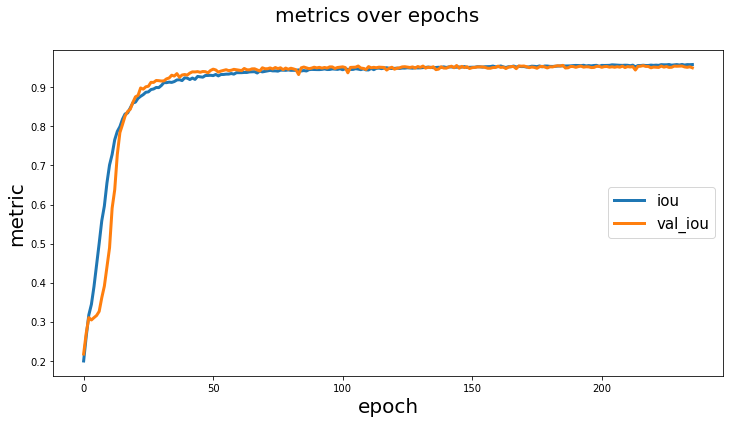

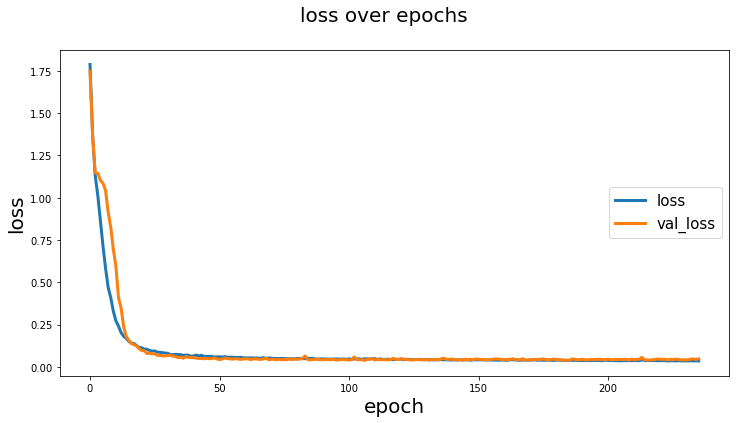

In [31]:
# from tensorflow.keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [36]:
model.load_weights(model_filename)
preds_test = np.zeros_like(X_test)
for i in range(50):
    inp = X_test[i,:,:,:]
    out = model.predict(np.expand_dims(inp, axis=0))
    preds_test[i,:,:,:] = out
preds_test_t = (preds_test > 0.5).astype(np.uint8)

Post Processing

In [115]:
def postprocessing(mask):
    (thresh, blackAndWhiteImage) = cv2.threshold(np.uint8(mask*255), 127, 255, cv2.THRESH_BINARY)
    im_floodfill = blackAndWhiteImage.copy()

    h, w = blackAndWhiteImage.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    cv2.floodFill(im_floodfill, mask, (0,0), 255);

    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    im_out = blackAndWhiteImage | im_floodfill_inv
    
    return np.float32(im_out/255.0)

def remove_small_cts(img):
    img = np.uint8(img*255)
#     print(dtype(img))
    cnts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 5000:
            cv2.drawContours(img, [c], -1, (0,0,0), -1)
    return np.float32(img/255.0)

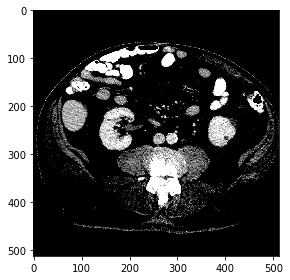

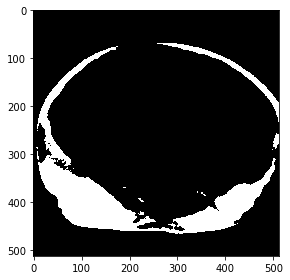

In [56]:
ix = 43
path = TEST_PATH + test_ids[ix]
img = read_dicom(path, 160, 50)
img.shape
out = model.predict(np.expand_dims(img, axis=0))
out[out > 0.5] = 1.0
out[out < 0.5] = 0.0
imshow(img)
plt.show()

imshow(out[0,:,:,2])
plt.show()

In [59]:
ix = 43
path = TEST_PATH + test_ids[ix]
img = read_dicom(path, 350, 50)

out = model.predict(np.expand_dims(img, axis=0))
out[out > 0.5] = 1.0
out[out < 0.5] = 0.0

preds_test_t[ix,:,:,0] = out[0,:,:,0]

In [63]:
i1 = preds_test_t[ix,:,:,0]
i2 = preds_test_t[ix,:,:,1]
i3 = preds_test_t[ix,:,:,2]

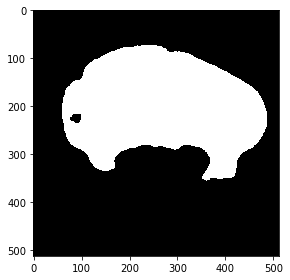

In [64]:
i2 = remove_small_cts(i2)
imshow(np.squeeze(i2))
plt.show()

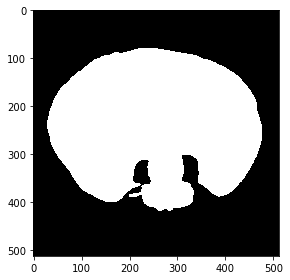

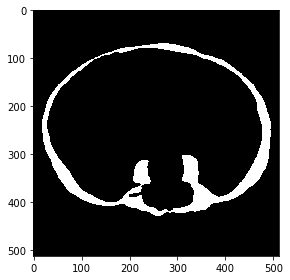

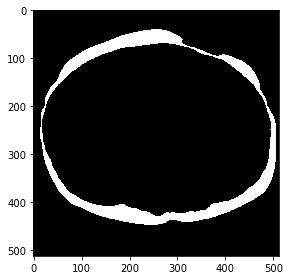

In [276]:
# imshow(np.squeeze(np.float32(preds_test_t[ix, :, :, 2])))
# plt.show()

i1 = postprocessing(i1)
i2 = postprocessing(i2)
i3 = postprocessing(i3)

i2[i1>0.5]=0
i3[i1>0.5]=0
i3[i2>0.5]=0

imshow(np.squeeze(i1))
plt.show()

imshow(np.squeeze(i2))
plt.show()

imshow(np.squeeze(i3))
plt.show()

In [277]:
preds_test_t[ix,:,:,0] = i1
preds_test_t[ix,:,:,1] = i2
preds_test_t[ix,:,:,2] = i3

In [437]:
def remove_small_cts(img):
    img = np.uint8(img*255)
#     print(dtype(img))
    cnts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 3000:
            cv2.drawContours(img, [c], -1, (0,0,0), -1)
    return np.float32(img/255.0)


In [33]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python\
def rle_encode(mask_image):
    pixels = mask_image.flatten()
    # We avoid issues with '1' at the start or end (at the corners of
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask,
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return runs

def rle_encode_(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def my_encode(mask):
    x = np.zeros((mask.shape[0], mask.shape[1], 1))
    x[mask[:,:,0] > 0.5] = 1
    x[mask[:,:,1] > 0.5] = 2
    x[mask[:,:,2] > 0.5] = 3
    
    return x

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    encoded = my_encode(lab_img)
    imshow(np.squeeze(np.float32(encoded)))
    plt.show()
    for i in range(1, 4):
        yield rle_encode(encoded == i)

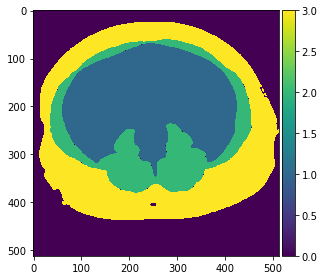

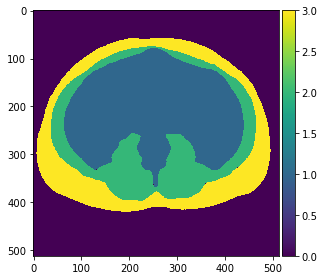

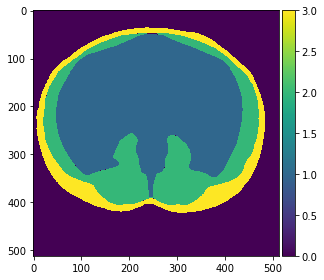

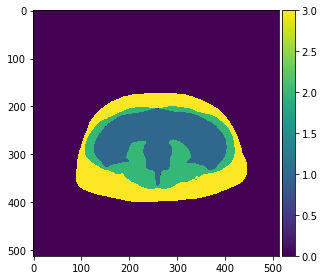

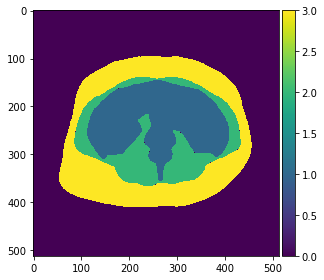

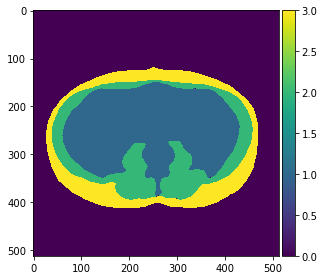

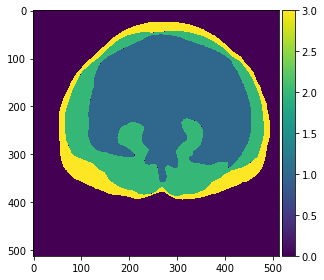

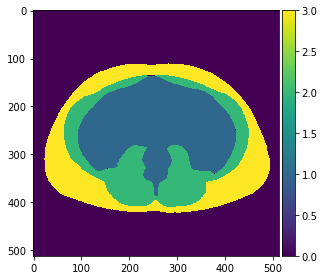

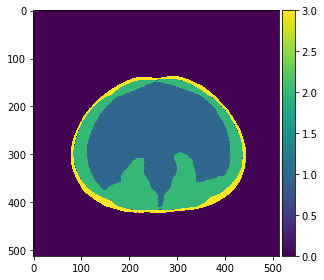

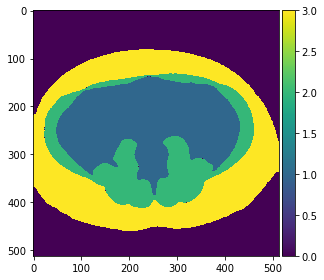

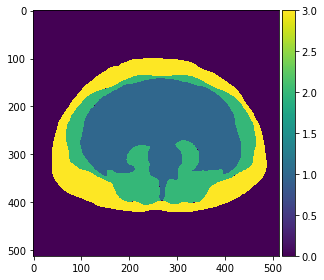

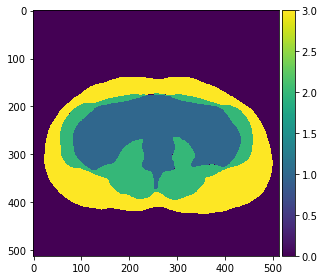

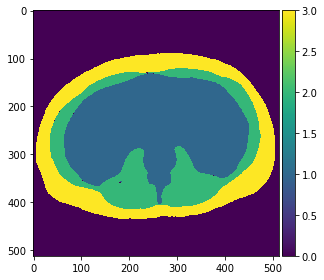

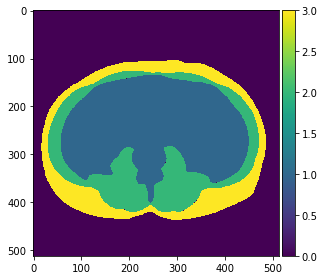

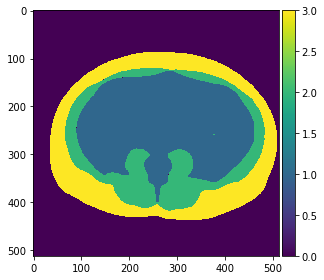

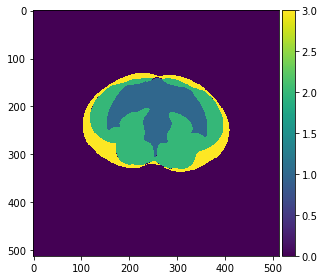

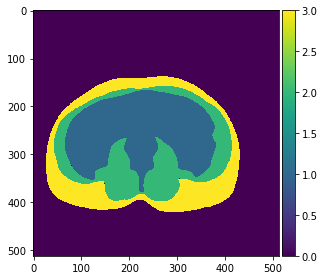

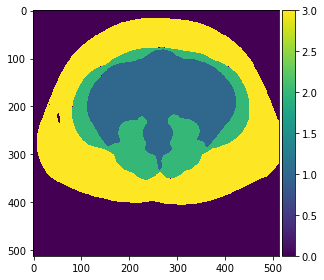

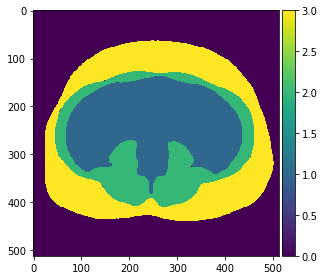

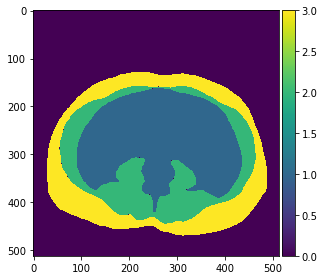

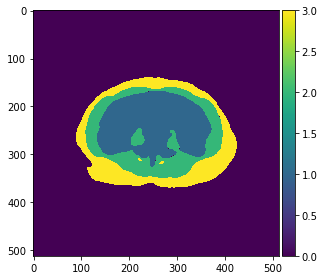

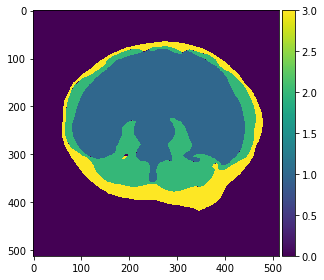

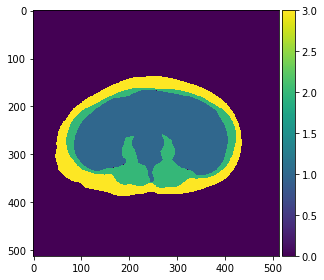

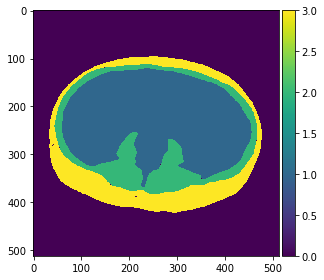

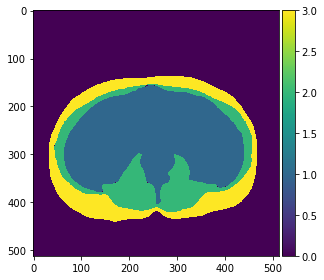

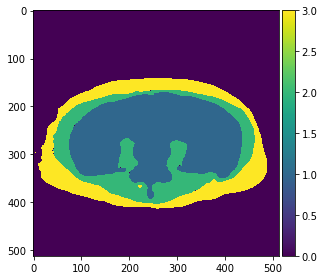

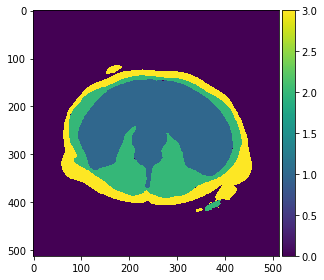

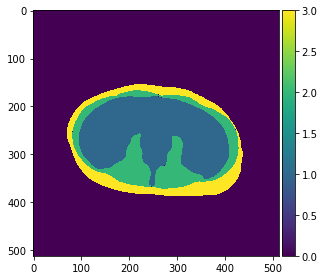

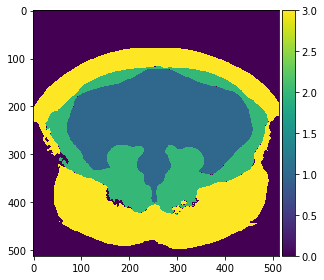

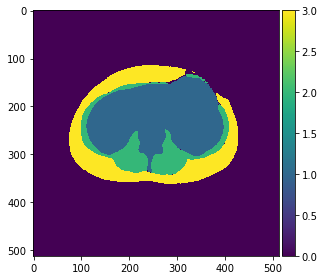

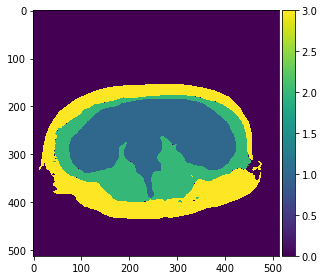

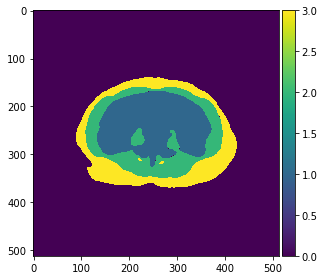

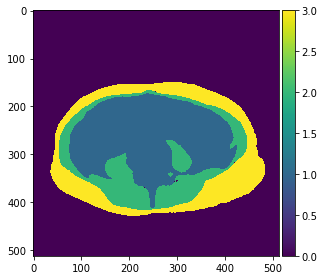

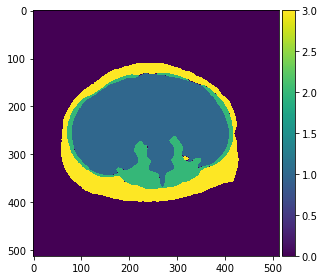

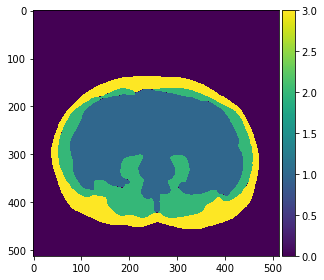

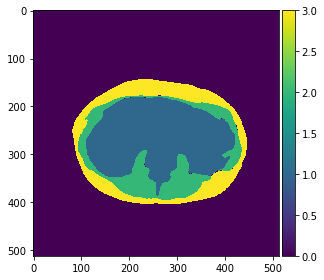

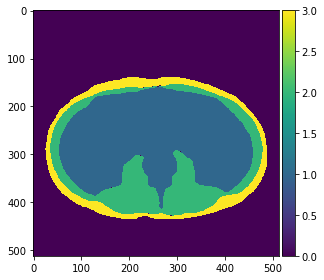

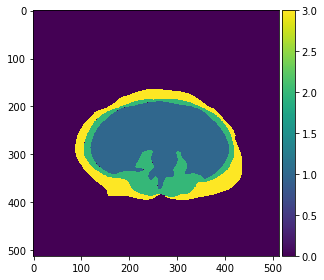

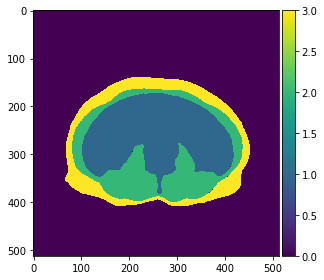

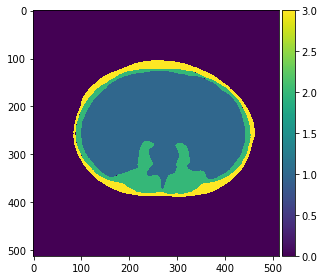

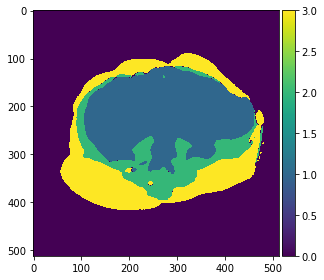

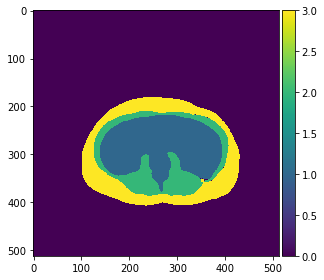

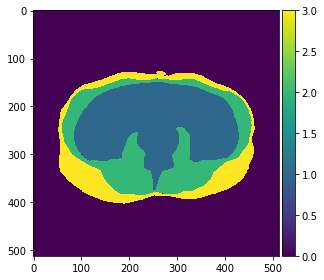

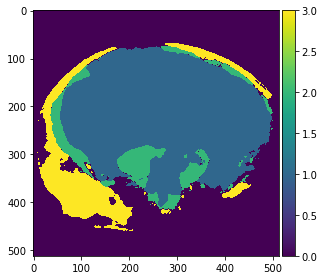

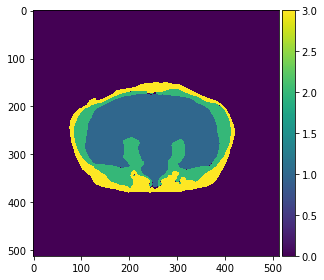

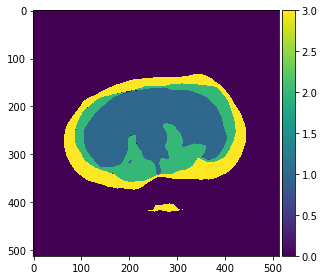

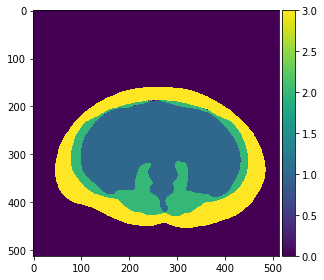

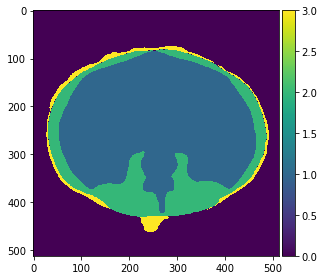

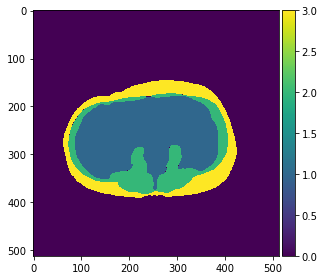

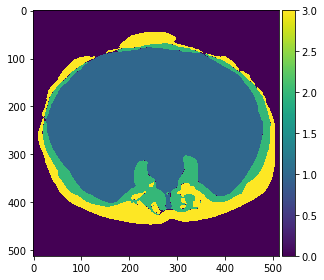

In [37]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_t[n]))
    rles.extend(rle)
    for k in range(len(rle)):
        new_test_ids.extend([id_[:-4] + '_' + str(k+1)])

Submission

In [38]:
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('submission.csv', index=False)